## Pipeline for Initial Data:

1) Make playlist JSON DF using json_concat_pipeline

2) Read Songs CSV

3) Run playlist_songs on playlist DF and songs DF

4) Remove all but relevant X data

## Pipeline for new playlist:
1) Import playlist using new_playlist
2) Label with model


## Imports

In [1]:
import json
import pandas as pd
import spotipy
import numpy as np
from spotipy.oauth2 import SpotifyClientCredentials
import os.path
from os import path
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA


spotify = spotipy.Spotify(auth_manager=SpotifyClientCredentials())
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

## **Json Playlist to DF** - json_concat_pipeline

In [2]:
def json_concat_pipeline(min_followers, num_tracks, first, last):
    
    '''Return Pandas DF of playlists with min number of followers, with first, last to set range 
    
    min_num_followers: minimum number of followers a playlist must have to make the list
    first: first document to pull from (starts at 0)
    last: inclusive last document (a last of n value will have a doc with name range mpd.slice.n*1000 - n*1000+999.json)
    
    '''
    df = pd.DataFrame()
    start = 1000*first
    for i in range(first,last+1):
        data = json.load(open(f'./data/mpd.slice.{start}-{start+999}.json'))
        df_pl = pd.DataFrame(data["playlists"])
        filt = (df_pl['num_followers'] >= min_followers) & (df_pl['num_tracks'] >= num_tracks)
        df_filt = df_pl[filt]
        df_filt.drop(['pid','description'], axis=1, inplace=True)
        start += 1000
        df = df.append(df_filt)
        
#     df.to_csv(f'./csv/playlist_{min_followers}f_{num_tracks}t_{first}_{last}.csv')
                
    return df

## **Tracks to CSV by Batch - get_all_tracks_csv**

In [3]:
def get_all_tracks_csv(first, last):
    '''Will request all tracks from playlists in json database from first document to last'''
    start = 1000*first
    for i in range(first,last):
        data = json.load(open(f'./data/mpd.slice.{start}-{start+999}.json'))
        df_pl = pd.DataFrame(data["playlists"])
        df_pl.drop(columns='description', inplace=True)
        df_pl.dropna(inplace=True)
        songs = pd.DataFrame(columns=['track_uri'])
                      
        
        for j in range(df_pl.shape[0]):
            tracks = pd.DataFrame(df_pl.iloc[j]['tracks'])
            tracks = tracks[['artist_name','track_name','duration_ms', 'album_name', 'track_uri']]
            tracks.dropna(inplace=True)
                                    
            splits = len(tracks.track_uri)
            if splits>200:
                num_splits = (splits//150)
            else:
                num_splits = 2
                
            start1 = 0
            end1 = splits//num_splits
            for k in range(2,num_splits+1):
                tracklist = list(tracks.track_uri)[start1:end1]                             
                       
                start1 = start1+end1+1
                end1 = end1*k
                if len(tracklist) > 0:
                    track_req = spotify.audio_features(tracklist)
                    
                    tracks_df = pd.DataFrame(track_req)      
                    tracks_df = tracks_df.rename(columns={"uri": "track_uri"})
                    tracks_df.drop(['id', 'track_href', 'analysis_url', 'duration_ms'], axis=1, inplace=True)
                    songs = songs.append(tracks_df)
                    
                
        songs = songs.drop_duplicates(subset='track_uri')
        songs.drop(columns= ['type'], inplace=True)
        songs.to_csv(f'./csv/songs{start}-{start+999}.csv')
        start += 1000
    return songs

## **Batch Track CSV to All Tracks CSV** - batch_track_to_csv

In [4]:
def batch_track_to_csv(first, last, interval):
    df = pd.DataFrame()
    start = interval*first
    for i in range(first,last+1):
        if path.exists(f'./csv/songs{start}-{start+999}.csv'):
            data = pd.read_csv(f'./csv/songs{start}-{start+999}.csv')
            start += interval
            df = df.append(data)
            
        else:
            start += interval
    df = df.drop_duplicates(subset='track_uri')
    df.to_csv(f'./csv/songs{first*interval}-{(last*interval)-1}.csv')

## **Working DF with Songs in Playlist and Song Analysis Data** - playlist_songs


In [5]:
def playlist_songs(df, songs):
    '''
    Creates a CSV for all playlists containing song data for songs in the playlist  
    
    '''
    
    
    
    for i in range(df.shape[0]):
        playlist_tracks = pd.DataFrame(df.iloc[i]['tracks'])
        playlist_tracks.rename(columns={'pos':'playlist_name'}, inplace=True)
        playlist_tracks['playlist_name'] = df.iloc[i]['name']
        playlist_tracks['num_tracks'] = df.iloc[i]['num_tracks']
        playlist_tracks['num_albums'] = df.iloc[i]['num_albums']
        playlist_tracks['num_followers'] = df.iloc[i]['num_followers']
        playlist_tracks = playlist_tracks.merge(songs, how='left', on = 'track_uri')
        
        playlist_tracks.to_csv(f'./csv/playlist_master.csv', mode='a', header=False)
        if i%100 == 0:
            print(i)
    return 

## **Merge two CSV** - merge_two_csv

In [6]:
def merge_two_csv(first_path, second_path, destination_path):
    df = pd.read_csv(first_path, index_col=0)
    df2 = pd.read_csv(second_path, index_col=0)
    df = df.append(df2)
    df = df.drop_duplicates(subset='track_uri')
    df.to_csv(destination_path)

## **Get New Single Playlist DF** - new_playlist
Transform data from any playlist on spotify to predict cluster label

In [7]:
def new_playlist(uri):
    pl = spotify.playlist_items(uri, fields=None, market=None)
    plt = pd.DataFrame(pl['items'])
    lst = []
    songs = pd.DataFrame(columns=['track_uri'])
    for i in range(plt.shape[0]):
        lst.append(plt['track'][i]['uri'])
    
    splits = len(lst)
    if splits>200:
        num_splits = (splits//150)
    else:
        num_splits = 2

    start1 = 0
    end1 = splits//num_splits
    for k in range(2,num_splits+1):
        tracklist = lst[start1:end1]                             

        start1 = start1+end1+1
        end1 = end1*k
        if len(tracklist) > 0:
            track_req = spotify.audio_features(tracklist)

            tracks_df = pd.DataFrame(track_req)      
            tracks_df = tracks_df.rename(columns={"uri": "track_uri"})
            tracks_df.drop(['id', 'track_href', 'analysis_url', 'duration_ms'], axis=1, inplace=True)
            songs = songs.append(tracks_df)


    songs = songs.drop_duplicates(subset='track_uri')
    songs.drop(columns= ['type'], inplace=True)
    songs = songs[['danceability',
                     'key','loudness','mode','speechiness','acousticness','instrumentalness',
                     'liveness','valence','tempo']]
    songs = songs.agg({'danceability': [min, max, np.std, np.mean],
                        'loudness': [min, max, np.std, np.mean],
                        'mode': [min, max, np.std, np.mean],
                        'speechiness': [min, max, np.std, np.mean],
                        'acousticness': [min, max, np.std, np.mean],
                        'instrumentalness': [min, max, np.std, np.mean],
                        'liveness': [min, max, np.std, np.mean],
                        'valence': [min, max, np.std, np.mean],
                        'tempo': [min, max, np.std, np.mean]})
    songs = pd.DataFrame(songs.T.stack()).T
    
            
    return songs

## **Format playlist with song analysis to playlist stats dataframe for model** - playlist_X

In [85]:
def playlist_X(df):
    '''
    Format playlist with numerical song analysis data to playlist stats DF for X input matrix
    
    
    '''
    
#     df.drop(columns='Unnamed: 0.1', inplace=True)
    playlist_X = df[['playlist_name','danceability',
                     'key','loudness','mode','speechiness','acousticness','instrumentalness',
                     'liveness','valence','tempo', 'num_tracks']]
    playlist_X_stats = playlist_X.groupby(['playlist_name','num_tracks']).agg({'danceability': [min, max, np.std, np.mean],
                                                                'loudness': [min, max, np.std, np.mean],
                                                                'mode': [min, max, np.std, np.mean],
                                                                'speechiness': [min, max, np.std, np.mean],
                                                                'acousticness': [min, max, np.std, np.mean],
                                                                'instrumentalness': [min, max, np.std, np.mean],
                                                                'liveness': [min, max, np.std, np.mean],
                                                                'valence': [min, max, np.std, np.mean],
                                                                'tempo': [min, max, np.std, np.mean]}).reset_index(level=1)
    playlist_X_stats.dropna(inplace=True)
    playlist_X_stats.drop(columns='num_tracks', inplace=True)
    return playlist_X_stats

In [16]:
playlists = json_concat_pipeline(2, 5, 301, 309)

In [673]:
#get_all_tracks_csv(308, 999) #Finished 309

AttributeError: 'NoneType' object has no attribute 'keys'

In [10]:
songs = pd.read_csv('./csv/songs0-309999.csv', index_col=0)


In [18]:
playlist_master = pd.read_csv('./csv/playlist_master.csv', index_col=0)

/home/george/anaconda3/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [86]:
playlist_analysis = playlist_X(playlist_master)

/home/george/anaconda3/lib/python3.7/site-packages/pandas/core/generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


In [87]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
mstats = scaler.fit_transform(playlist_analysis.iloc[:,:])

In [61]:
from sklearn.decomposition import PCA
pca = PCA(n_components=10) #pca object
mstats = pca.fit_transform(mstats)
evr = pca.explained_variance_ratio_
print(evr)
print("The 12 principal components explain {0:0.1f}%"
      " of the variance in the original data.".format(evr.sum()*100))

[0.2892046  0.14619396 0.10404057 0.09211588 0.0762472  0.06116825
 0.04278711 0.03876188 0.02979063 0.02738628]
The 12 principal components explain 90.8% of the variance in the original data.


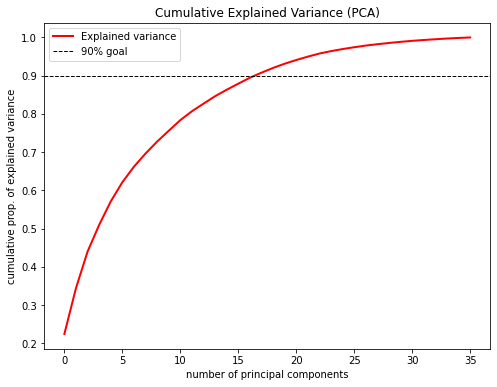

In [33]:
import matplotlib.pyplot as plt

total_variance = np.sum(pca.explained_variance_)
cum_variance = np.cumsum(pca.explained_variance_)
prop_var_expl = cum_variance/total_variance

fig, ax = plt.subplots(figsize=(8,6))
ax.plot(prop_var_expl, color='red', linewidth=2, label='Explained variance')
ax.axhline(0.9, label='90% goal', linestyle='--', color="black", linewidth=1)
ax.set_ylabel('cumulative prop. of explained variance')
ax.set_xlabel('number of principal components')
ax.legend();
plt.title('Cumulative Explained Variance (PCA)')
plt.savefig('./img/cumulative_var_pca.png', dpi=200)

array([[<AxesSubplot:title={'center':"('acousticness', 'mean')"}>,
        <AxesSubplot:title={'center':"('acousticness', 'std')"}>,
        <AxesSubplot:title={'center':"('danceability', 'mean')"}>,
        <AxesSubplot:title={'center':"('danceability', 'std')"}>],
       [<AxesSubplot:title={'center':"('instrumentalness', 'mean')"}>,
        <AxesSubplot:title={'center':"('instrumentalness', 'std')"}>,
        <AxesSubplot:title={'center':"('liveness', 'mean')"}>,
        <AxesSubplot:title={'center':"('liveness', 'std')"}>],
       [<AxesSubplot:title={'center':"('loudness', 'mean')"}>,
        <AxesSubplot:title={'center':"('loudness', 'std')"}>,
        <AxesSubplot:title={'center':"('mode', 'mean')"}>,
        <AxesSubplot:title={'center':"('mode', 'std')"}>],
       [<AxesSubplot:title={'center':"('speechiness', 'mean')"}>,
        <AxesSubplot:title={'center':"('speechiness', 'std')"}>,
        <AxesSubplot:title={'center':"('tempo', 'mean')"}>,
        <AxesSubplot:title={'cen

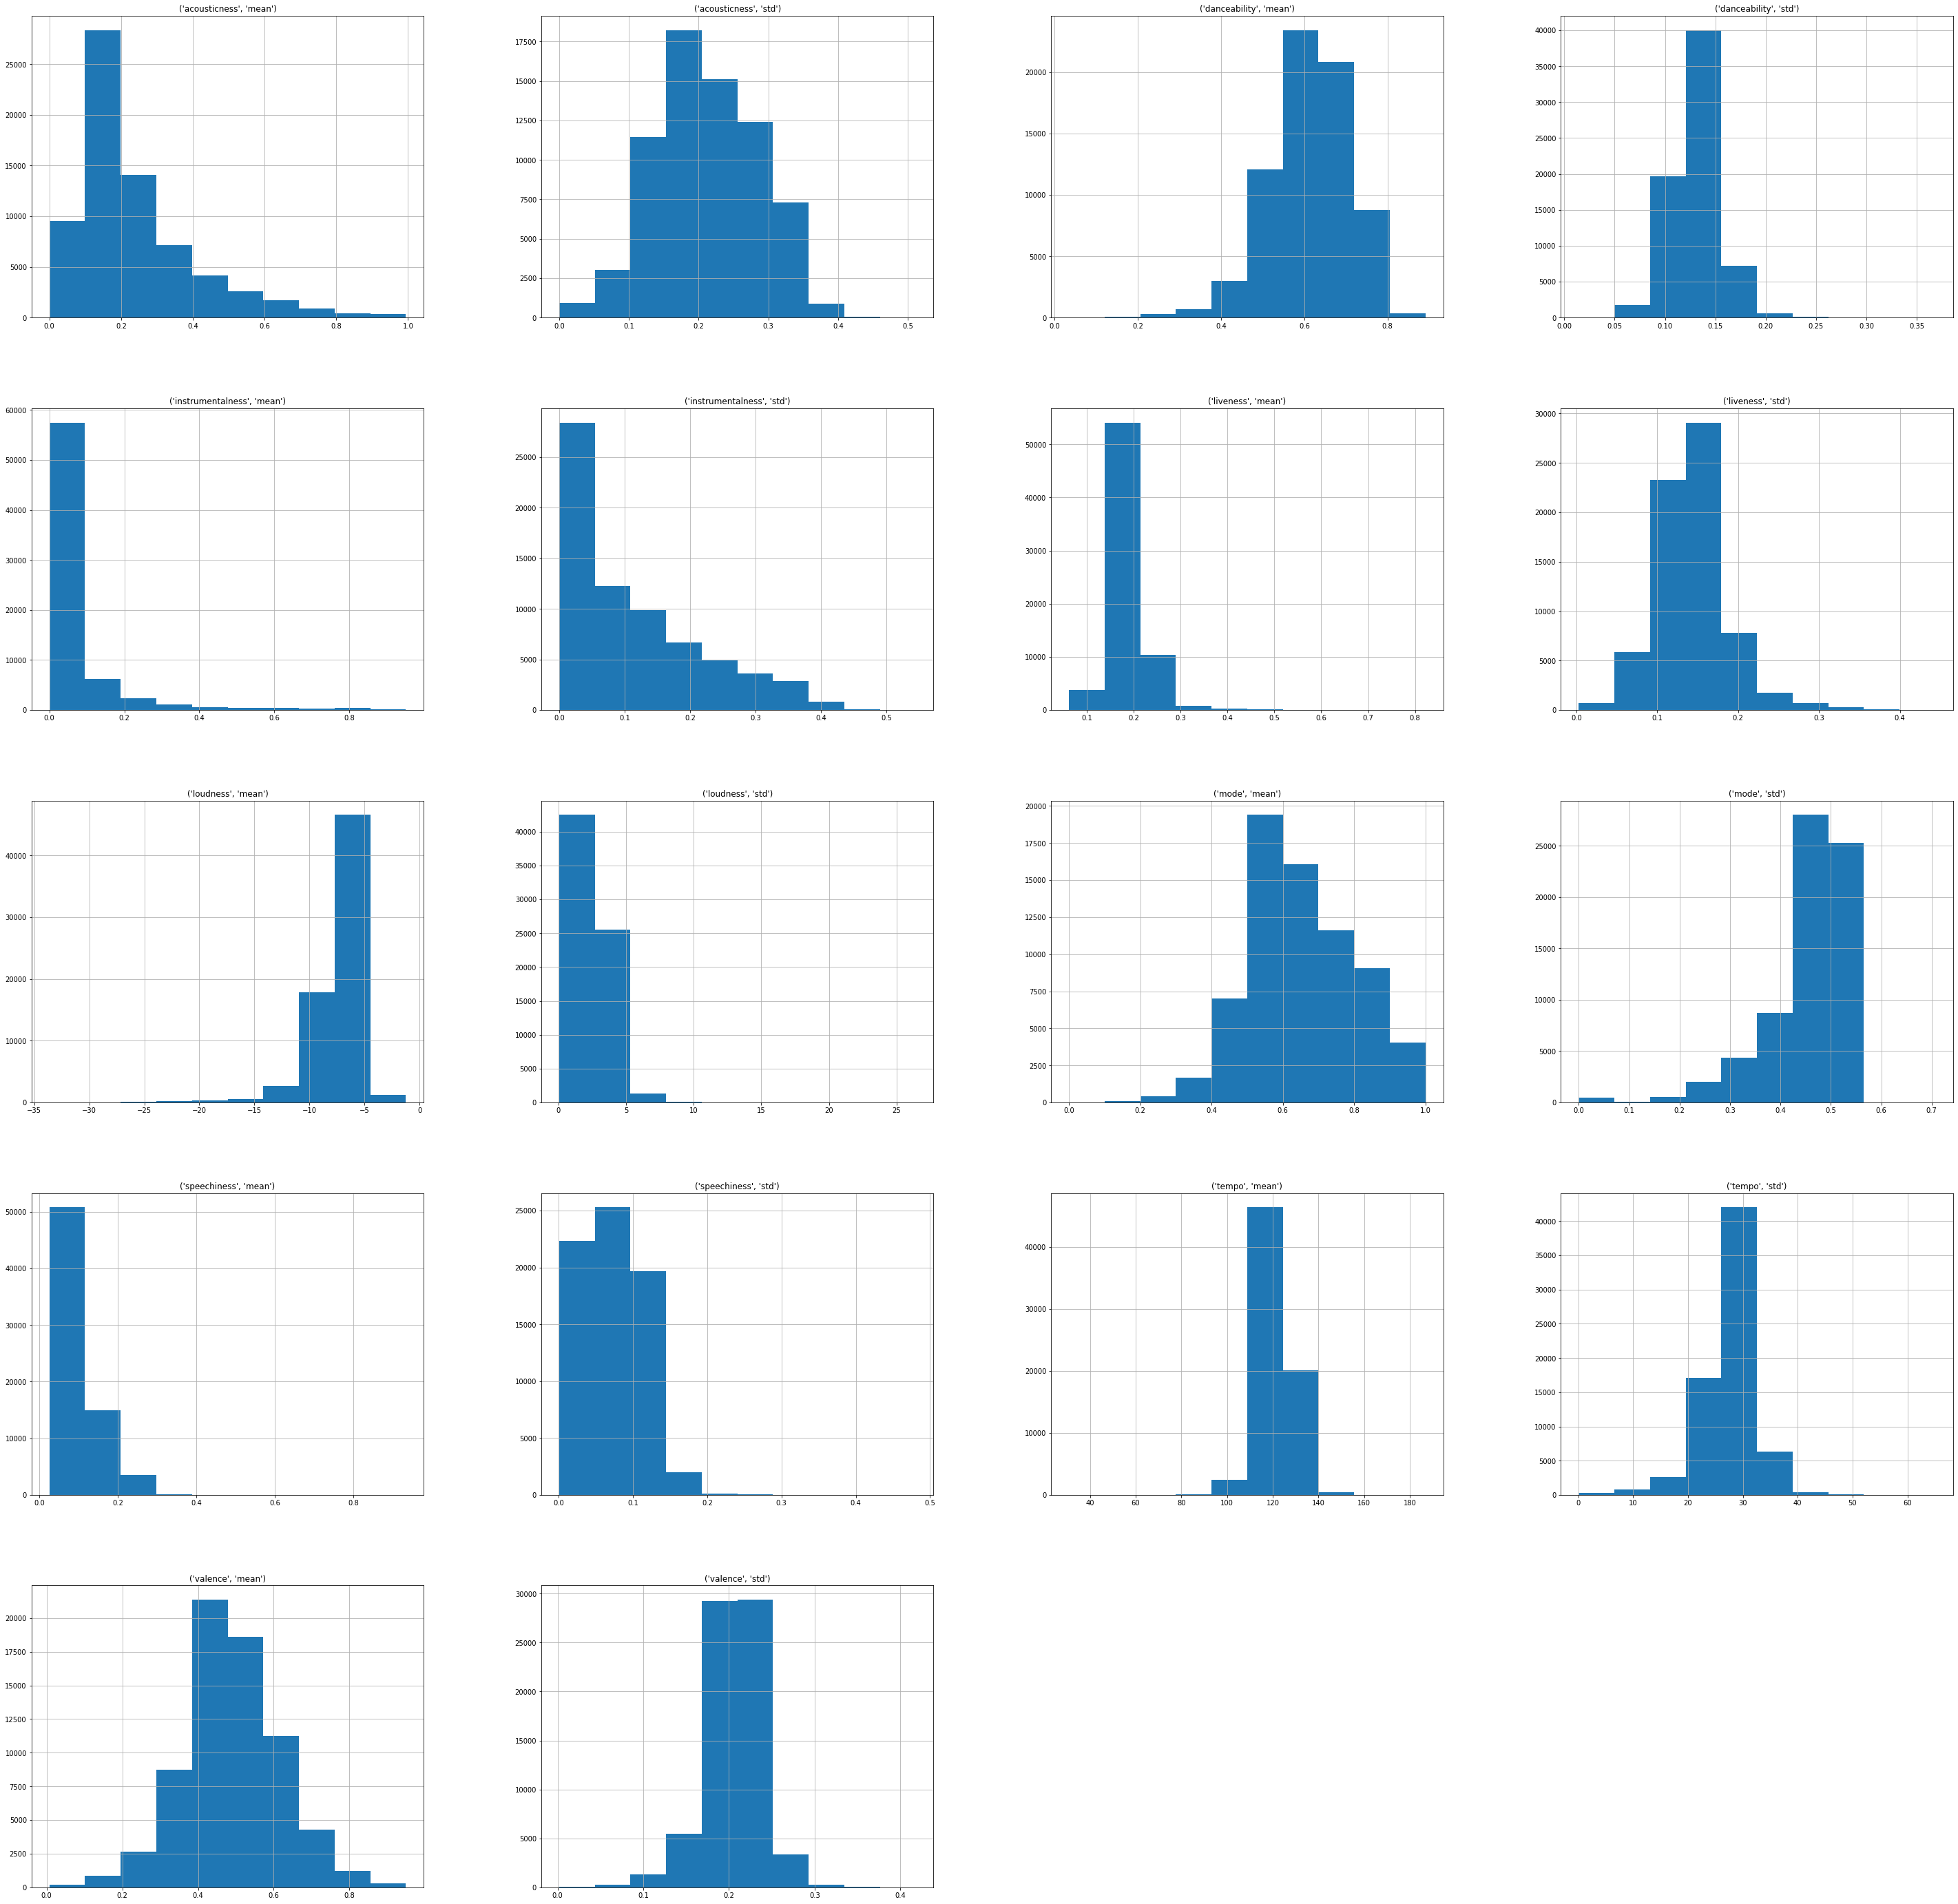

In [60]:
playlist_analysis.hist(figsize=(50,50))


In [66]:
playlist_analysis.corr().describe()

danceability              loudness                  mode            speechiness            acousticness            instrumentalness              liveness               valence                 tempo           
               std       mean        std       mean        std       mean         std       mean          std       mean              std       mean        std       mean        std       mean        std       mean
count    18.000000  18.000000  18.000000  18.000000  18.000000  18.000000   18.000000  18.000000    18.000000  18.000000        18.000000  18.000000  18.000000  18.000000  18.000000  18.000000  18.000000  18.000000
mean      0.134335   0.043193   0.070345  -0.014406   0.067241  -0.028209    0.110718   0.092829     0.046219   0.003107         0.071112   0.027803   0.103244   0.095992   0.122658   0.041888   0.073087   0.028368
std       0.298027   0.452671   0.442033   0.476763   0.377283   0.391035    0.406667   0.417601     0.404325   0.472529         0.359950   0.393743   0.312533   0.331707   0.241875   0.320080   0.273616   0.313052
min      -0.298723  -0.481443  -0.773312  -0.814922  -0.802938  -0.802938   -0.491687  -0.458094    -0.443862  -0.814922        -0.361733  -0.595965  -0.223411  -0.280605  -0.106853  -0.351860  -0.248012  -0.419253
25%      -0.022835  -0.369388  -0.225777  -0.345980  -0.122525  -0.165067   -0.213817  -0.247512    -0.260209  -0.316871        -0.184724  -0.208027  -0.048734  -0.053839   0.012124  -0.199737  -0.060700  -0.129228
50%       0.099418  -0.018225   0.004042   0.107805   0.050622  -0.018451    0.058843   0.023124    -0.020680  -0.165132        -0.027901  -0.078423   0.017550  -0.009879   0.073764   0.006975   0.020321   0.017051
75%       0.277075   0.439667   0.405459   0.263514   0.164392   0.159627    0.238035   0.246160     0.289287   0.293728         0.222263   0.170162   0.120589   0.178635   0.123125   0.118694   0.191115   0.075574
max       1.000000   1.000000   1.000000   1.000000   1.000000   1.000000    1.000000   1.000000     1.000000   1.000000         1.000000   1.000000   1.000000   1.000000   1.000000   1.000000   1.000000   1.000000

### Fit KNN

In [88]:
from sklearn.neighbors import NearestNeighbors
knn = NearestNeighbors(n_neighbors=5, algorithm = 'auto')
knn.fit(mstats)

NearestNeighbors()

### Find Nearest Playlists from new Playlist

In [131]:
def new_playlist(uri, playlist_analysis, playlist_master):
    pl = spotify.playlist_items(uri, fields=None, market=None)
    plt = pd.DataFrame(pl['items'])
    lst = []
    songs = pd.DataFrame(columns=['track_uri'])
    for i in range(plt.shape[0]):
        lst.append(plt['track'][i]['uri'])
    
    splits = len(lst)
    if splits>200:
        num_splits = (splits//150)
    else:
        num_splits = 2

    start1 = 0
    end1 = splits//num_splits
    for k in range(2,num_splits+1):
        tracklist = lst[start1:end1]                             

        start1 = start1+end1+1
        end1 = end1*k
        if len(tracklist) > 0:
            track_req = spotify.audio_features(tracklist)

            tracks_df = pd.DataFrame(track_req)      
            tracks_df = tracks_df.rename(columns={"uri": "track_uri"})
            tracks_df.drop(['id', 'track_href', 'analysis_url', 'duration_ms'], axis=1, inplace=True)
            songs = songs.append(tracks_df)


    songs = songs.drop_duplicates(subset='track_uri')
    songs.drop(columns= ['type'], inplace=True)
    songs = songs[['danceability',
                     'key','loudness','mode','speechiness','acousticness','instrumentalness',
                     'liveness','valence','tempo']]
    songs = songs.agg({'danceability': [min, max, np.std, np.mean],
                        'loudness': [min, max, np.std, np.mean],
                        'mode': [min, max, np.std, np.mean],
                        'speechiness': [min, max, np.std, np.mean],
                        'acousticness': [min, max, np.std, np.mean],
                        'instrumentalness': [min, max, np.std, np.mean],
                        'liveness': [min, max, np.std, np.mean],
                        'valence': [min, max, np.std, np.mean],
                        'tempo': [min, max, np.std, np.mean]})
    songs = pd.DataFrame(songs.T.stack()).T
    songs = scaler.transform(np.array(songs).reshape(1,-1))
    indices = knn.kneighbors(songs, 5, return_distance=False)
    
#     cluster = gm.predict(songs)[0]
    
    neighbors = pd.DataFrame()
    for i in indices[0]:
        neighbors = neighbors.append(playlist_master[playlist_master['playlist_name']==playlist_analysis.iloc[i].name])
        
    return neighbors[['playlist_name','artist_name','track_name', 'album_name']]

In [132]:
neighbors = new_playlist('https://open.spotify.com/playlist/37i9dQZF1DZ06evO1UOgRq', playlist_analysis, playlist_master)

In [126]:
import pickle

neighbors.to_pickle('./land')

In [133]:
neighbors.groupby('artist_name').count().sort_values(by='playlist_name', ascending=False).head(50)

,playlist_name,track_name,album_name
artist_name,,,
The Script,40,40,40
The Fray,12,12,12
OneRepublic,12,12,12
Miley Cyrus,9,9,9
Nick Jonas,9,9,9
Ariana Grande,8,8,8
Sabrina Carpenter,8,8,8
Usher,7,7,7
The Weeknd,6,6,6


In [134]:
neighbors['artist_name'].unique()

array(['The 1975', 'Catfish and the Bottlemen', 'The Neighbourhood',
       'Twenty One Pilots', 'Basement', 'Turnover', 'Bad Suns',
       'This Wild Life', 'Tyler Carter', 'Maudlin Strangers',
       'Balance And Composure', 'BØRNS', 'Modern Baseball',
       'Arctic Monkeys', 'Moose Blood', 'Beach Weather', 'Pvris',
       'The Wonder Years', 'Neck Deep', 'Real Friends', 'LANY', 'MAX',
       'blackbear', 'OneRepublic', 'The Fray', 'The Script',
       'Vertical Horizon', 'Ingrid Michaelson', 'Rascal Flatts',
       'Mads Langer', 'Natalie Merchant', 'Timbaland', 'Silje Nergaard',
       'The Cult', 'You+Me', 'Passenger', 'Lifehouse', 'James Blunt',
       'Daniel Bedingfield', 'O.A.R.', 'Papa Roach', 'Finger Eleven',
       'Theory of a Deadman', 'Shinedown', 'Staind', 'Saliva',
       '3 Doors Down', 'Linkin Park', 'Hinder', 'Sia', 'Zara Larsson',
       'Dr. Dre', 'Johnny Cash', 'DJ Khaled', 'The Cinematic Orchestra',
       'Jetta', 'X Ambassadors', 'Milky Chance', 'Florence + T

In [137]:
neighbors.head(50)

,playlist_name,artist_name,track_name,album_name
0,here you go,The 1975,Somebody Else,"I like it when you sleep, for you are so beaut..."
1,here you go,Catfish and the Bottlemen,Business,The Balcony
2,here you go,The Neighbourhood,Daddy Issues,Wiped Out!
3,here you go,Twenty One Pilots,Ride,Blurryface
4,here you go,Basement,Oversized,Promise Everything
5,here you go,Turnover,New Scream,Peripheral Vision
6,here you go,Bad Suns,Cardiac Arrest,Language & Perspective
7,here you go,This Wild Life,History,Clouded
8,here you go,Tyler Carter,Georgia,Leave Your Love
9,here you go,Maudlin Strangers,Overdose,Overdose
